In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas

import copy
import itertools

In [2]:
# CHOOSE DATASET

# Regression dataset
data = datasets.load_diabetes(as_frame=True)

X = data.data.values
y = data.target.values 
X.shape


(442, 10)

In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In [5]:
 # Number of clusters 
n_clusters = 2
m=1.5

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [6]:
centers.shape

(2, 11)

In [7]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.9397243469978676


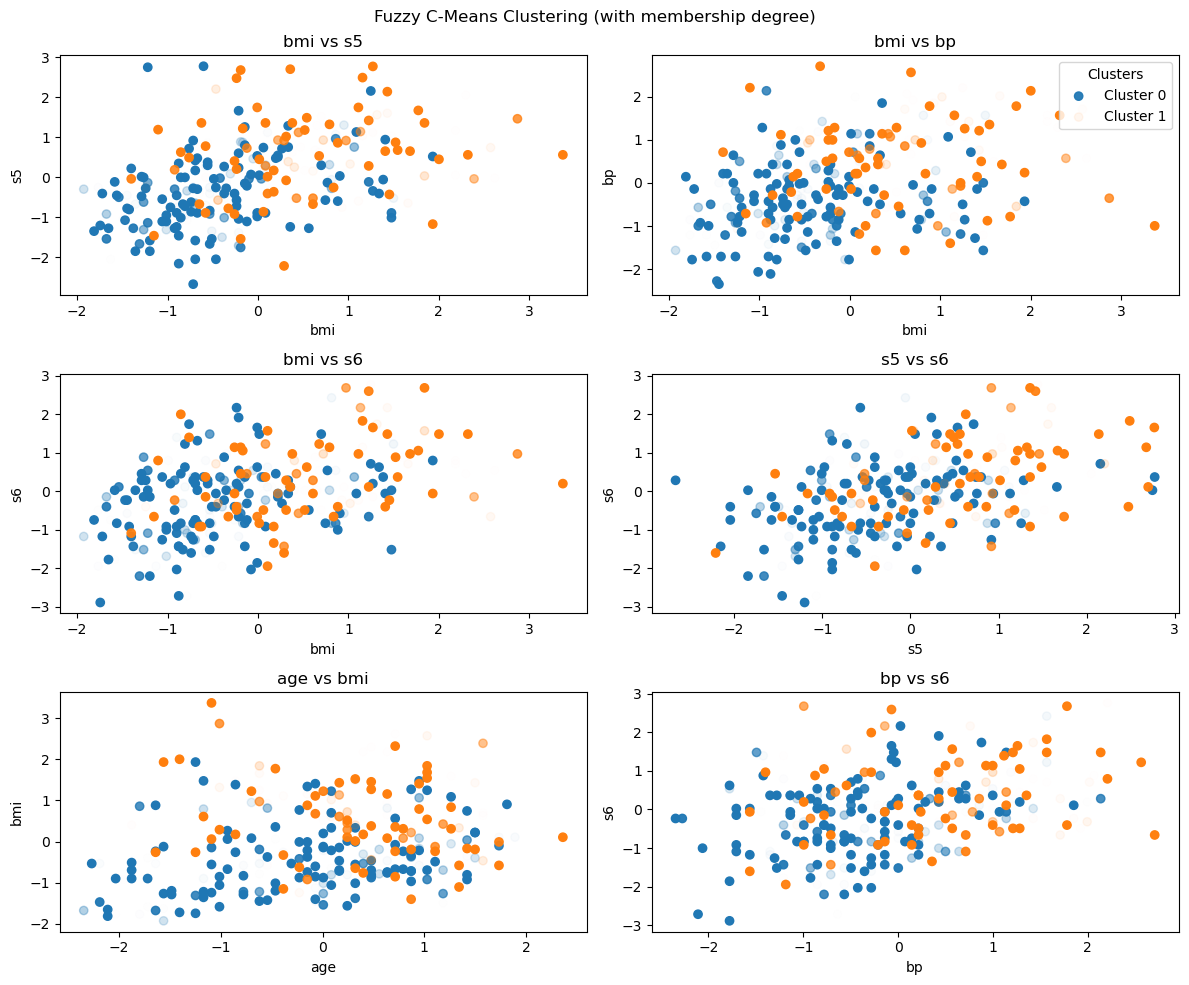

In [8]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Diabetes feature names (sklearn's load_diabetes ordering)
feature_names = [
    "age",  # 0
    "sex",  # 1
    "bmi",  # 2
    "bp",   # 3
    "s1",   # 4 (tc)
    "s2",   # 5 (ldl)
    "s3",   # 6 (hdl)
    "s4",   # 7 (tch)
    "s5",   # 8 (ltg)
    "s6"    # 9 (glu)
]

# Choose 6 feature pairs (indices in Xexp)
pairs = [
    (2, 8),  # bmi vs s5 (both strong predictors)
    (2, 3),  # bmi vs bp
    (2, 9),  # bmi vs glu
    (8, 9),  # s5 vs glu
    (0, 2),  # age vs bmi
    (3, 9)   # bp vs glu
]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, (i, j) in zip(axes.ravel(), pairs):
    # Plot 2 features with fuzzy membership
    for k in range(n_clusters):
        ax.scatter(
            Xexp[cluster_labels == k, i],   # Feature i
            Xexp[cluster_labels == k, j],   # Feature j
            alpha=u[k, :],                  # transparency ~ membership degree
            label=f'Cluster {k}'
        )
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f"{feature_names[i]} vs {feature_names[j]}")

fig.suptitle("Fuzzy C-Means Clustering (with membership degree)")
axes[0, 1].legend(title="Clusters", loc="upper right")
plt.tight_layout()
plt.show()

fig.savefig("../Plots/Fuzzy C-Means Clustering (with membership degree) REG.pdf", format="pdf", bbox_inches="tight")

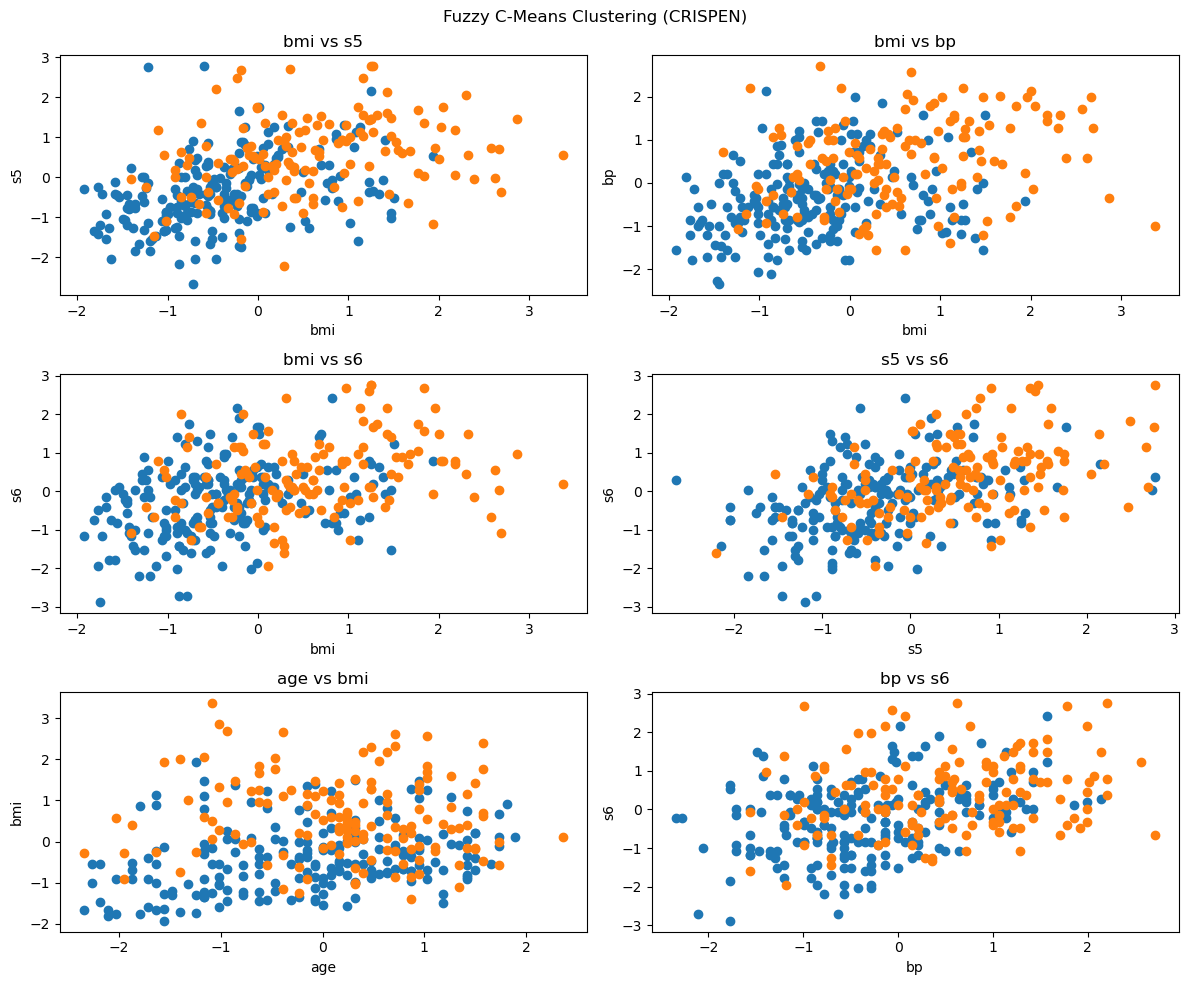

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, (i, j) in zip(axes.ravel(), pairs):
    # Plot 2 features with fuzzy membership
    for k in range(n_clusters):
        ax.scatter(
            Xexp[cluster_labels == k, i],
            Xexp[cluster_labels == k, j],
            label=f'Cluster {k}'
        )
        
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f"{feature_names[i]} vs {feature_names[j]}")

fig.suptitle("Fuzzy C-Means Clustering (CRISPEN)")
fig.tight_layout()
fig.show()

fig.savefig("../Plots/Fuzzy C-Means Clustering (CRISPEN) REG.pdf", format="pdf", bbox_inches="tight")

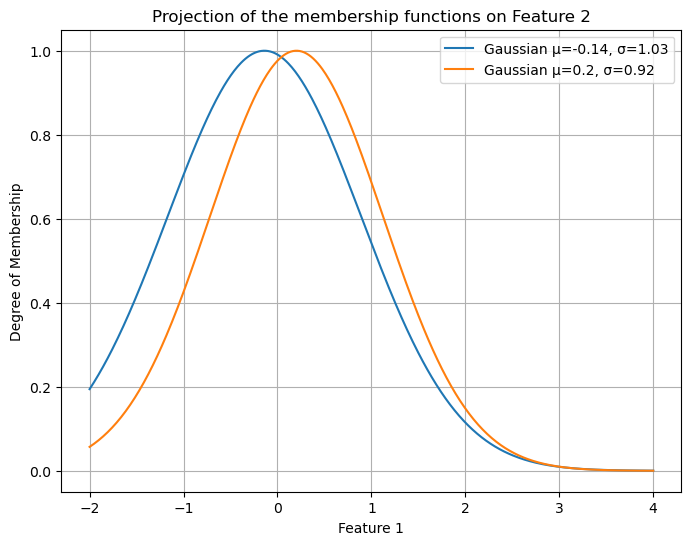

In [10]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [12]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [13]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        #print(loss)
        loss.backward()
        optimizer.step()


In [14]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [15]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [16]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [17]:
param_grid = {
    "max_iters": [3, 5, 7],
    "gd_epochs": [10, 20, 50],
    "lr": [1e-2, 1e-3, 3e-4]
}

results = []

for max_iters, gd_epochs, lr in itertools.product(
    param_grid["max_iters"],
    param_grid["gd_epochs"],
    param_grid["lr"]
):
    m = copy.deepcopy(model)
    train_hybrid_anfis(m, Xtr, ytr.reshape(-1,1),
                       max_iters=max_iters,
                       gd_epochs=gd_epochs,
                       lr=lr)
    
    # forward pass
    y_pred, _, _ = m(Xte)
    
    # compute accuracy
    rse = mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())
    
    # save result as dict
    results.append({
        "max_iters": max_iters,
        "gd_epochs": gd_epochs,
        "lr": lr,
        "rse": rse
    })

# Convert to DataFrame
df = pandas.DataFrame(results)

# Sort by accuracy (descending)
df = df.sort_values(by="rse", ascending=True).reset_index(drop=True)

print(df)

    max_iters  gd_epochs      lr          rse
0           7         10  0.0010  2467.229492
1           5         50  0.0003  2467.691162
2           3         20  0.0010  2471.629395
3           5         10  0.0010  2475.580811
4           7         20  0.0003  2482.711182
5           3         50  0.0003  2482.890869
6           3         10  0.0010  2491.051025
7           5         20  0.0010  2492.055176
8           5         20  0.0003  2492.248047
9           7         10  0.0003  2499.420410
10          3         20  0.0003  2504.705811
11          5         10  0.0003  2509.311768
12          7         50  0.0003  2509.433350
13          3         10  0.0003  2518.557129
14          7         20  0.0010  2573.880859
15          3         50  0.0010  2592.305664
16          3         10  0.0100  2692.734619
17          5         50  0.0010  2698.375000
18          5         10  0.0100  2731.639160
19          7         50  0.0010  2741.678955
20          7         10  0.0100  

In [18]:
# Training with LS:
model_ls = copy.deepcopy(model)
train_ls(model_ls, Xtr, ytr.reshape(-1,1))

# Training with GD:
#model_gd = copy.deepcopy(model)
#train_gd(model_gd, Xtr, ytr.reshape(-1,1), epochs=100, lr=1e-3)

# Training with Hybrid (Classic ANFIS):
model_h = copy.deepcopy(model)
train_hybrid_anfis(model_h, Xtr, ytr.reshape(-1,1), max_iters=7, gd_epochs=10, lr=1e-3)

# Training with Alternative Hybrid (LS + GD):
#model_ah = copy.deepcopy(model)
#train_hybrid(model_ah, Xtr, ytr.reshape(-1,1), epochs=100, lr=1e-4)
    

In [19]:
y_pred, _, _=model_ls(Xte)
#performance metric for regression
print(f'LS MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression
#y_pred, _, _=model_gd(Xte)
#performance metric for regression
#print(f'GD MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression
y_pred, _, _=model_h(Xte)
#performance metric for regression
print(f'H  MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression
#y_pred, _, _=model_ah(Xte)
#performance metric for regression
#print(f'AH MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

LS MSE:2534.129638671875
H  MSE:2467.22802734375


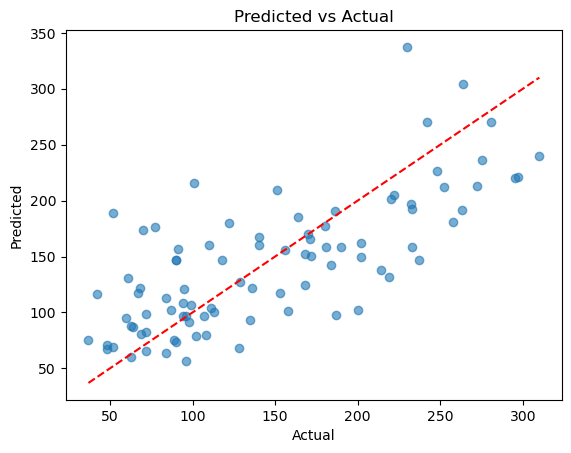

<Figure size 640x480 with 0 Axes>

In [20]:
plt.scatter(yte, y_pred.detach().numpy(), alpha=0.6)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()
plt.savefig("../Plots/PredictedActualANFIS.pdf", format="pdf", bbox_inches="tight")